In [15]:
# Adversarial Neural Cryptography - https://arxiv.org/pdf/1610.06918.pdf

In [16]:
# Necessary imports
import torch
import random

import numpy as np
from torch import nn

import matplotlib.pyplot as plt

In [17]:
# Define the length of the key and the message
pln_txt_len = sec_key_len = cip_txt_len = N = 16

In [18]:
# Function to generate a random plain text and a secret key
def create_batch(plain_text_len, secret_key_len, batch_size):
    plain_text = torch.zeros(batch_size, plain_text_len)
    secret_key = torch.zeros(batch_size, secret_key_len)
    
    for i in range(batch_size):
        for j in range(plain_text_len):
            plain_text[i][j] = random.randint(0, 1)
        for j in range(secret_key_len):
            secret_key[i][j] = random.randint(0, 1)
            
    return plain_text.float(), secret_key.float()

plain_text, secret_key = create_batch(pln_txt_len, sec_key_len, 256)
print(plain_text.shape, secret_key.shape)

torch.Size([256, 16]) torch.Size([256, 16])


In [19]:
# Alice's network

class Alice_Net(nn.Module):
    def __init__(self, plain_text_len, secret_key_len, cipher_text_len):
        super(Alice_Net, self).__init__()
        self.input_size  = plain_text_len + secret_key_len
        self.output_size = cipher_text_len
        
        self.W = nn.Sequential(
            nn.Linear(self.input_size, self.input_size),
            nn.Tanh(),
        )
        
        self.C = nn.Sequential(
            nn.Conv1d(1, 2, 4, stride=1, padding=2),
            nn.Tanh(),  
            nn.Conv1d(2, 4, 2, stride=2, padding=0),
            nn.Tanh(), 
            nn.Conv1d(4, 4, 1, stride=1, padding=0),
            nn.Tanh(),   
            nn.Conv1d(4, 1, 1, stride=1, padding=0),
            nn.Sigmoid(),      
        )
        
    def forward(self, plain_text, secret_key):
        x = torch.cat((plain_text, secret_key), axis=-1)
        x = torch.unsqueeze(x, 1)
        
        x = self.W(x)
        x = self.C(x)
        
        x = torch.squeeze(x, 1)
        return x
    
    def encrypt(self, plain_text, secret_key):
        encrypted_text = self.forward(plain_text, secret_key)
        return torch.as_tensor((encrypted_text - 0.5) > 0, dtype=torch.float32)

In [20]:
# Bob's network

class Bob_Net(nn.Module):
    def __init__(self, plain_text_len, secret_key_len, cipher_text_len):
        super(Bob_Net, self).__init__()
        self.input_size  = cipher_text_len + secret_key_len
        self.output_size = plain_text_len
        
        self.W = nn.Sequential(
            nn.Linear(self.input_size, self.input_size),
            nn.Tanh(),
        )
        
        self.C = nn.Sequential(
            nn.Conv1d(1, 2, 4, stride=1, padding=2),
            nn.Tanh(),  
            nn.Conv1d(2, 4, 2, stride=2, padding=0),
            nn.Tanh(), 
            nn.Conv1d(4, 4, 1, stride=1, padding=0),
            nn.Tanh(),   
            nn.Conv1d(4, 1, 1, stride=1, padding=0),
            nn.Sigmoid(),      
        )
        
    def forward(self, cipher_text, secret_key):
        x = torch.cat((cipher_text, secret_key), axis=-1)
        x = torch.unsqueeze(x, 1)
        
        x = self.W(x)
        x = self.C(x)
        
        x = torch.squeeze(x, 1)
        return x
    
    def decrypt(self, cipher_text, secret_key):
        decrypted_text = self.forward(cipher_text, secret_key)
        return torch.as_tensor((decrypted_text - 0.5) > 0, dtype=torch.float32)

In [21]:
# Eve's network

class Eve_Net(nn.Module):
    def __init__(self, plain_text_len, cipher_text_len):
        super(Eve_Net, self).__init__()
        self.input_size  = cipher_text_len
        self.output_size = plain_text_len
        
        self.W = nn.Sequential(
            nn.Linear(self.input_size, 2 * self.input_size),
            nn.Tanh(),
        )
        
        self.C = nn.Sequential(
            nn.Conv1d(1, 2, 4, stride=1, padding=2),
            nn.Tanh(),  
            nn.Conv1d(2, 4, 2, stride=2, padding=0),
            nn.Tanh(), 
            nn.Conv1d(4, 4, 1, stride=1, padding=0),
            nn.Tanh(),   
            nn.Conv1d(4, 1, 1, stride=1, padding=0),
            nn.Sigmoid(),      
        )
        
    def forward(self, cipher_text):
        x = torch.unsqueeze(cipher_text, 1)
        
        x = self.W(x)
        x = self.C(x)
        
        x = torch.squeeze(x, 1)
        return x
    
    def eavesdrop(self, cipher_text):
        eavesdrop_text = self.forward(cipher_text)
        return torch.as_tensor((eavesdrop_text - 0.5) > 0, dtype=torch.float32)

In [22]:
# Define the device

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla T4


In [23]:
# Instantiate the models

Alice = Alice_Net(pln_txt_len, sec_key_len, cip_txt_len).to(device)
Bob   = Bob_Net(pln_txt_len, sec_key_len, cip_txt_len).to(device)
Eve   = Eve_Net(pln_txt_len, cip_txt_len).to(device)

print("All models instantiated successfully !!!")

All models instantiated successfully !!!


In [24]:
# Hyperparameters
n_epochs   = 20
eve_edge   = 2

train_size = 2 ** 16
batch_size = 512

# Define the optimizers
lr = 0.0008

optim_Alice_Bob = torch.optim.Adam(list(Alice.parameters()) + list(Bob.parameters()), lr=lr)
optim_Eve   = torch.optim.Adam(Eve.parameters(), lr=lr)

optimizers  = [optim_Alice_Bob, optim_Eve]

In [25]:
# Custom Loss functions
class AliceBobLoss(nn.Module):
    def __init__(self):
        super(AliceBobLoss, self).__init__()
    
    def forward(self, plain_text, decrypted_text, alice_eve_loss):
        loss = torch.mean(torch.sum(torch.abs(torch.sub(plain_text,decrypted_text)), 1))
        # loss += (1 - 2 * alice_eve_loss.item())**2
        loss += ((N/2 - alice_eve_loss.item())**2)/((N/2)**2)
        return loss
    
class AliceEveLoss(nn.Module):
    def __init__(self):
        super(AliceEveLoss, self).__init__()
    
    def forward(self, plain_text, eavesdrop_text):
        return torch.mean(torch.sum(torch.abs(torch.sub(plain_text,eavesdrop_text)), 1))
    
criterion_AliceBob = AliceBobLoss()
criterion_AliceEve = AliceEveLoss()

criterions = [criterion_AliceBob, criterion_AliceEve]

def hamming_distance(x, y):
    return torch.sum(torch.abs(x - y))

In [26]:
# Train the networks
# Eve is trained eve_edge times for every training of Alice and Bob

def train(Alice, Bob, Eve, criterions, optimizers, train_size=10000, eve_edge=2, n_epochs=100, batch_size=256):
    print("Training started ...")
    
    # Initialize the losses
    n_batches = train_size // batch_size
    alice_bob_dist, alice_eve_dist = np.zeros(n_epochs * n_batches), np.zeros(n_epochs * n_batches)
    
    for epoch in range(n_epochs):
        bob_dist, eve_dist = np.zeros(n_batches), np.zeros(n_batches)
        alice_eve_loss = torch.tensor(sec_key_len * 0.5, requires_grad=True, device=device)
                
        for batch in range(n_batches):            
            plain_text, secret_key = create_batch(pln_txt_len, sec_key_len, batch_size)
            plain_text, secret_key = plain_text.to(device), secret_key.to(device)
        
            # Train Alice and Bob
            optimizers[0].zero_grad()
        
            encrypted_text = Alice(plain_text, secret_key)
            decrypted_text = Bob(encrypted_text, secret_key)

            # Expectation of the loss
            eve_loss = criterions[1](plain_text, Eve(encrypted_text))
            # bob_loss = criterions[0](plain_text, decrypted_text, alice_eve_loss)
            bob_loss = criterions[0](plain_text, decrypted_text, eve_loss)
            
            bob_loss.backward()
            optimizers[0].step()

            # Train Eve
            for _ in range(eve_edge):
                plain_text, secret_key = create_batch(pln_txt_len, sec_key_len, batch_size)
                plain_text, secret_key = plain_text.to(device), secret_key.to(device)
            
                optimizers[1].zero_grad()
                
                # Detach the encrypted text from the graph to prevent backpropagation
                encrypted_text = Alice(plain_text, secret_key).detach()
                eavesdrop_text = Eve(encrypted_text)
            
                # Expectation of the loss
                eve_loss = criterions[1](plain_text, eavesdrop_text)                
                alice_eve_loss = min(alice_eve_loss, eve_loss)
                
                # eve_loss.backward(retain_graph=True)
                alice_eve_loss.backward(retain_graph=True)
                optimizers[1].step()
                
            # Validation for Alice, Bob and Eve
            with torch.no_grad():
                plain_text, secret_key = create_batch(pln_txt_len, sec_key_len, 128)
                plain_text, secret_key = plain_text.to(device), secret_key.to(device)
            
                encrypted_text = Alice.encrypt(plain_text, secret_key)
                decrypted_text = Bob.decrypt(encrypted_text, secret_key)
                eavesdrop_text = Eve.eavesdrop(encrypted_text)
            
                ab = hamming_distance(decrypted_text, plain_text).cpu().numpy() / 128 * 1.0
                ae = hamming_distance(eavesdrop_text, plain_text).cpu().numpy() / 128 * 1.0
                
                alice_bob_dist[epoch * n_batches + batch] = bob_dist[batch] = ab
                alice_eve_dist[epoch * n_batches + batch] = eve_dist[batch] = ae
                
            print("\rEpoch: {}/{} | Batch: {}/{} | Bob: {:.4f} | Eve: {:.4f}".format(epoch+1, n_epochs, batch+1, n_batches, bob_loss, eve_loss), end="", flush=True)
              
        print("\rEpoch: {}/{} | Average number of bits wrong (of {}) Bob: {} , Eve: {}".format(epoch+1, n_epochs, sec_key_len, np.round(np.mean(bob_dist), 4), np.round(np.mean(eve_dist), 4)), end='\n', flush=True)
    
    print("\rTraining completed !!!")
    return alice_bob_dist, alice_eve_dist
    
# Set the models to train mode
Alice.train()
Bob.train()
Eve.train()

ab_dist, ae_dist = train(Alice, Bob, Eve, criterions, optimizers, train_size, eve_edge, n_epochs, batch_size)

Training started ...
Epoch: 1/20 | Average number of bits wrong (of 16) Bob: 8.0021 , Eve: 8.0021
Epoch: 2/20 | Average number of bits wrong (of 16) Bob: 5.791 , Eve: 6.8809
Epoch: 3/20 | Average number of bits wrong (of 16) Bob: 3.2401 , Eve: 6.0313
Epoch: 4/20 | Average number of bits wrong (of 16) Bob: 2.8098 , Eve: 7.763
Epoch: 5/20 | Average number of bits wrong (of 16) Bob: 2.6462 , Eve: 7.9616
Epoch: 6/20 | Average number of bits wrong (of 16) Bob: 2.5458 , Eve: 7.9717
Epoch: 7/20 | Average number of bits wrong (of 16) Bob: 2.5148 , Eve: 7.9627
Epoch: 8/20 | Average number of bits wrong (of 16) Bob: 2.4896 , Eve: 7.9916
Epoch: 9/20 | Average number of bits wrong (of 16) Bob: 2.4294 , Eve: 7.9854
Epoch: 10/20 | Average number of bits wrong (of 16) Bob: 2.3943 , Eve: 7.9868
Epoch: 11/20 | Average number of bits wrong (of 16) Bob: 2.3622 , Eve: 7.9894
Epoch: 12/20 | Average number of bits wrong (of 16) Bob: 2.3466 , Eve: 7.9861
Epoch: 13/20 | Average number of bits wrong (of 16) Bo

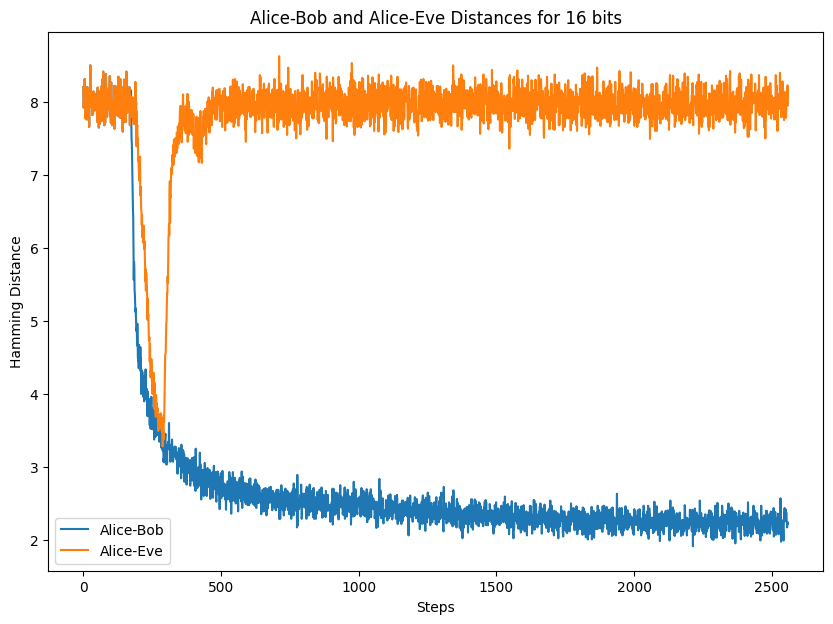

In [27]:
# Plot the results
plt.figure(figsize=(10, 7))
plt.title("Alice-Bob and Alice-Eve Distances for {} bits".format(sec_key_len))

steps = np.arange(ab_dist.shape[0])
plt.plot(steps, ab_dist, label="Alice-Bob")
plt.plot(steps, ae_dist, label="Alice-Eve")
plt.ylabel("Hamming Distance")
plt.xlabel("Steps")

plt.legend()
plt.show()

In [28]:
# Set the models to evaluation mode
Alice.eval()
Bob.eval()
Eve.eval()

# Test the networks
plain_text, secret_key = create_batch(pln_txt_len, sec_key_len, 1)
plain_text, secret_key = plain_text.to(device), secret_key.to(device)

print("Plain text: ", plain_text.cpu().squeeze().numpy())

encrypted_text = Alice.encrypt(plain_text, secret_key)
print("Encrypted text: ", encrypted_text.detach().cpu().squeeze().numpy())
      
decrypted_text = Bob.decrypt(encrypted_text, secret_key)
print("Bob's decrypted text: {}, Distance: {:.4f}".format(decrypted_text.detach().cpu().squeeze().numpy(), hamming_distance(decrypted_text, plain_text).item()))

eavesdrop_text = Eve.eavesdrop(encrypted_text)
print("Eve's eavesdrop text: {}, Distance: {:.4f}".format(eavesdrop_text.detach().cpu().squeeze().numpy(), hamming_distance(eavesdrop_text, plain_text).item()))

Plain text:  [0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0.]
Encrypted text:  [1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0.]
Bob's decrypted text: [0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0.], Distance: 2.0000
Eve's eavesdrop text: [0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.], Distance: 7.0000
